# Rede neural 65622 - Transformada em classificador
Melhor desempenho considerando o critério de maior cos_sim e menor loss 

In [1]:
# Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
from pickle import dump, load
from sklearn.metrics import confusion_matrix
# from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", 300)

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(Net, self).__init__()
        self.num_layers = num_layers

        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size[0])])
        for i in range(0, self.num_layers-2):
            self.linears.extend([nn.Linear(layers_size[i], layers_size[i+1])])              
        self.linears.append(nn.Linear(layers_size[-1], output_size))

# Última camada sem função de ativação --> crossentropy já aplica softmax
# ReLU em intermediárias
    def forward(self, x):
        for layer in self.linears[0:-1]:                   
            x = F.relu(layer(x))
        x = (self.linears[-1](x))
        return(x)

# # Aplicando função de ativação na última camada tbm
# ### Tentar mudar pra sigmoide se deixar a normalização de 0,1
#     def forward(self, x):
#         for layer in self.linears:                   
#             x = torch.sigmoid(layer(x))
# #             x = F.relu(layer(x))
#         return(x)

In [3]:
def nonRepeatedRandomInt(low, upper, N):
        import numpy as np
        import random
        
        numbers = np.arange(low, upper, 1)
        random.shuffle(numbers)
        shuffleNumbers = np.array(numbers)[0:int(N)]
                
        return shuffleNumbers

In [4]:
def createSurrogate(X):
    Xsur  = np.zeros_like(X)
    for i in range(X.shape[1]):
        Xsur[:,i] = X[nonRepeatedRandomInt(0, X.shape[0], X.shape[0]),i]
    return Xsur

In [5]:
def save_checkpoint(state, is_best, filename='model_best.pth.tar'):
    if is_best:
        torch.save(state, filename)
        print('*****Saved epoch: %d *****' % (state['epoch']))

In [6]:
def ls(p,y):
    M = np.shape(p)[1]
    beta = np.empty((M))
    py = np.transpose(p).dot(y)
    covP = np.linalg.inv(np.transpose(p).dot(p))
    beta =  covP.dot(py)
    return beta

In [7]:
# testes = pd.read_csv("D:/TG-Biomed/Regression_model/Loop_Testes_Regressao2.csv")
# rede = testes.iloc[np.where(testes["index"]==65622)]
# rede

In [8]:
# print(rede.iloc[0,1])

In [9]:
# Read clean data (features <10% excluded) = 25 features
data = pd.read_pickle("data_closed_rigid_o_adjusted_clean")
pf50 = np.round(data["PF50_closed_rigid"].values, 2)

In [10]:
# Usar todas as 24 características + ones
features = data.copy()
features.drop("PF50_closed_rigid", axis=1, inplace=True)

features_names = features.columns
print('Features: ',list(features_names))
X = features.values.astype('float')
y = pf50.reshape(len(pf50), 1)

Features:  ['Age', 'AgeGroup', 'Gender', 'Height', 'Weight', 'BMI', 'FootLen', 'Ystudy', 'Illness', 'Nmedication', 'Ortho-Prosthesis', 'Disability', 'Falls12m', 'AngiotensinIIreceptorantagonist', 'HMGCoAreductaseinhibitor', 'Syntheticthyroidhormone', 'Hypercholesterolemia_total', 'Hypertension_total', 'Hypothyroidism_total', 'Normal Shoes_total', 'Sandal_FlipFlop_total', 'Dental_total', 'Corrective_lens', 'Hearing_dis_ortho_total', 'Ones']


In [11]:
# Separando o dataset em treino/vali e teste (treino/vali 70%, teste 30%)
X_train_vali, X_test, y_train_vali, y_test = train_test_split(X, y, test_size=0.3)

# Divide em classes de acordo com a os quartis do dado de treino/vali
quart = np.quantile(y_train_vali,[0.25, 0.5, 0.75])
print(quart)
y_train_vali_class = np.digitize(y_train_vali, quart)
y_test_class = np.digitize(y_test, quart)
print((y_train_vali_class).shape)
print((y_test_class).shape)

[0.12 0.17 0.21]
(144, 1)
(63, 1)


In [12]:
# # Salvando os dados em datasets separados

# np.save('X_test.npy', X_test)
# np.save('y_test.npy', y_test)
# np.save('y_test_class.npy', y_test_class)
# np.save('X_train_vali.npy', X_train_vali)
# np.save('y_train_vali.npy', y_train_vali)
# np.save('y_train_vali_class.npy', y_train_vali_class)

In [13]:
# Separando o treino da vali (treino 90% = 63% total, validação 10% = 7% total)
# random_state = rede.iloc[0,6]
Nnets = 2000
random_state = 12779
# random_state = np.random.randint(0, Nnets*10, 1)[0]   # Deixar o high variável?
print('Random State: %d' % (random_state))
X_train, X_vali, y_train_class, y_vali_class = train_test_split(X_train_vali, y_train_vali_class, test_size=0.1, random_state=random_state)

# Escalamento e Transformação dos dados
scaler_x = RobustScaler(with_centering=True)
X_train_scaled = scaler_x.fit_transform(X_train)
X_vali_scaled = scaler_x.transform(X_vali)
X_test_scaled = scaler_x.transform(X_test)

# save the scaler
# dump(scaler_x, open('scaler_x.pkl', 'wb'))

# # load the scaler
# scaler = load(open('scaler_x.pkl', 'rb'))

Random State: 12779


(129, 1)


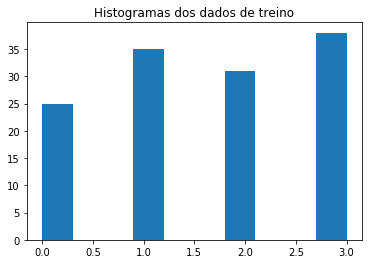

In [14]:
print(y_train_class.shape)
plt.figure()
n, bins, patches = plt.hist(y_train_class)
plt.title("Histogramas dos dados de treino")
plt.show()

(63, 1)


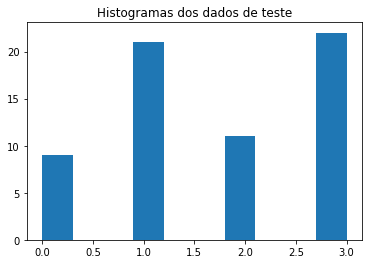

In [15]:
print(y_test_class.shape)
plt.figure()
n, bins, patches = plt.hist(y_test_class)
plt.title("Histogramas dos dados de teste")
plt.show()

(15, 1)


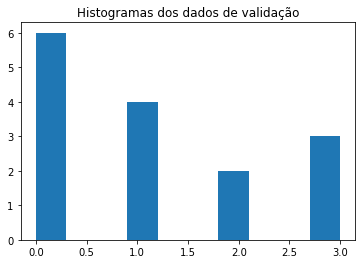

In [16]:
print(y_vali_class.shape)
plt.figure()
n, bins, patches = plt.hist(y_vali_class)
plt.title("Histogramas dos dados de validação")
plt.show()

In [17]:
# # SMOTE - Data Augmentation
# print('Data train: %d' % (X_train.shape[0]))
# sm = SMOTE(k_neighbors=3, random_state=42)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# print('Data train resample: %d' % (X_train_res.shape[0]))

# # Histograma dos dados de treino resample
# print("Histograma dos dados de treino com Resample SMOTE")
# n_res, bins_res, patches_res = plt.hist(y_train_res)
# plt.title("Histograma dos dados de treino com Resample SMOTE")
# plt.show()

In [18]:
# Parâmetros da rede
torch.manual_seed(1234)

# num_layers = rede.iloc[0,2]
num_layers = 4
print('Number of layers: %d' % (num_layers))
# layer_init_size = 10
layer_init_size = np.random.randint(low=1, high=24)
print('Inicial size layer: %d' % (layer_init_size))
layer_2_size = np.random.randint(low=1, high=24)
layers_size = [layer_init_size, layer_2_size, 4]
# layers_size = np.linspace(layer_init_size, 4, num_layers-1, dtype=int)
print('Layers sizes:', list(layers_size))

net = Net(input_size=X.shape[1], num_layers=num_layers, layers_size=layers_size , output_size=4)

Number of layers: 4
Inicial size layer: 7
Layers sizes: [7, 23, 4]


In [19]:
X.shape[1]

25

In [20]:
net.parameters

<bound method Module.parameters of Net(
  (linears): ModuleList(
    (0): Linear(in_features=25, out_features=7, bias=True)
    (1): Linear(in_features=7, out_features=23, bias=True)
    (2): Linear(in_features=23, out_features=4, bias=True)
    (3): Linear(in_features=4, out_features=4, bias=True)
  )
)>

In [21]:
# Choose optmizer and loss function
criterion = nn.CrossEntropyLoss()
# criterion = nn.MultiLabelSoftMarginLoss()    # Testar

optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
# optimizer = torch.optim.SGD(net.parameters(), lr = 0.05, momentum = 0.9) # lr = learning rate 

# Treinamento utilizando o dado de treino transformado
# Aumento do número de epochs de 5000 para 100000
epochs = 50000
loss_train = np.zeros(epochs)
loss_vali = np.zeros(epochs)
acc_vali = np.zeros(epochs)
best_acc = 0

for epoch in range(epochs):
    
    inputs = torch.autograd.Variable(torch.Tensor(X_train_scaled.astype(np.float32)).float())
    targets = torch.autograd.Variable(torch.Tensor(y_train_class).long())
    
    optimizer.zero_grad()
    out = net(inputs)
    loss = criterion(out, targets.squeeze())
    loss.backward()
    optimizer.step()

    loss_train[epoch] = loss.item()
    
    # Validação
    if epoch == 0 or (epoch + 1) % 100 == 0:
        inputs_vali = torch.autograd.Variable(torch.Tensor(X_vali_scaled.astype(np.float32)).float())
        targets_vali = torch.autograd.Variable(torch.Tensor(y_vali_class).long())
        out_vali = net(inputs_vali)
        loss_v = criterion(out_vali, targets_vali.squeeze())

        loss_vali[epoch] = loss_v.item()
        
        # predicted = out.data
        _, predicted = torch.max(out_vali.data, 1) # Usar dessa forma?
        
        # Calcula acurácia
        error_count = y_vali_class.size - np.count_nonzero((targets_vali.squeeze() == predicted) .numpy())
        acc_vali[epoch] = 100 * torch.sum(targets_vali.squeeze() == predicted) / y_vali_class.size
        
        r_vali = np.corrcoef(predicted.detach().numpy().squeeze(), targets_vali.detach().numpy().squeeze())[0,1]
        
        # remember best acc and save best model
        is_best = acc_vali[epoch] >= best_acc
        best_acc = max(acc_vali[epoch], best_acc)
        save_checkpoint({
        'epoch': epoch + 1,
        #'arch': args.arch,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'loss': loss_v.item(),
        'R-corrcoef': r_vali,
        'optimizer' : optimizer.state_dict(),
        }, is_best)
        
        print('Epoch %d Loss: %.4f' % (epoch + 1, loss.item()))
        print('   Validation Loss: %.4f' % (loss_v.item()))
        print('   Errors: %d; Accuracy: %d%%' % (error_count, acc_vali[epoch]))
        print('   R-corrcoef: %s' % (str(r_vali)))


..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


*****Saved epoch: 1 *****
Epoch 1 Loss: 1.3993
   Validation Loss: 1.4054
   Errors: 13; Accuracy: 13%
   R-corrcoef: nan
*****Saved epoch: 100 *****
Epoch 100 Loss: 1.3096
   Validation Loss: 1.4082
   Errors: 11; Accuracy: 26%
   R-corrcoef: 0.31029628387040636
*****Saved epoch: 200 *****
Epoch 200 Loss: 1.1227
   Validation Loss: 1.5295
   Errors: 11; Accuracy: 26%
   R-corrcoef: 0.3203408235664684
Epoch 300 Loss: 0.9310
   Validation Loss: 1.8684
   Errors: 12; Accuracy: 20%
   R-corrcoef: 0.3199245925977438
Epoch 400 Loss: 0.7352
   Validation Loss: 2.4661
   Errors: 12; Accuracy: 20%
   R-corrcoef: 0.4669357606934496
Epoch 500 Loss: 0.5879
   Validation Loss: 3.6919
   Errors: 12; Accuracy: 20%
   R-corrcoef: 0.4669357606934496
*****Saved epoch: 600 *****
Epoch 600 Loss: 0.5045
   Validation Loss: 4.7966
   Errors: 11; Accuracy: 26%
   R-corrcoef: 0.4932090215534979
*****Saved epoch: 700 *****
Epoch 700 Loss: 0.4510
   Validation Loss: 5.8777
   Errors: 11; Accuracy: 26%
   R-cor

Epoch 7000 Loss: 0.0254
   Validation Loss: 44.9101
   Errors: 14; Accuracy: 6%
   R-corrcoef: -0.20194517395039002
Epoch 7100 Loss: 0.0252
   Validation Loss: 45.3131
   Errors: 14; Accuracy: 6%
   R-corrcoef: -0.20194517395039002
Epoch 7200 Loss: 0.0250
   Validation Loss: 45.6169
   Errors: 14; Accuracy: 6%
   R-corrcoef: -0.20194517395039002
Epoch 7300 Loss: 0.0248
   Validation Loss: 46.1128
   Errors: 14; Accuracy: 6%
   R-corrcoef: -0.20194517395039002
Epoch 7400 Loss: 0.0246
   Validation Loss: 46.3647
   Errors: 14; Accuracy: 6%
   R-corrcoef: -0.20194517395039002
Epoch 7500 Loss: 0.0244
   Validation Loss: 46.0978
   Errors: 14; Accuracy: 6%
   R-corrcoef: -0.20194517395039002
Epoch 7600 Loss: 0.0243
   Validation Loss: 46.3851
   Errors: 14; Accuracy: 6%
   R-corrcoef: -0.20194517395039002
Epoch 7700 Loss: 0.0241
   Validation Loss: 46.8230
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.01513415349215009
Epoch 7800 Loss: 0.0240
   Validation Loss: 47.0894
   Errors: 13; Accur

Epoch 14200 Loss: 0.0212
   Validation Loss: 67.6815
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.01513415349215009
Epoch 14300 Loss: 0.0212
   Validation Loss: 67.6292
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.01513415349215009
Epoch 14400 Loss: 0.0212
   Validation Loss: 67.6293
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.01513415349215009
Epoch 14500 Loss: 0.0212
   Validation Loss: 67.5890
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.01513415349215009
Epoch 14600 Loss: 0.0212
   Validation Loss: 67.4204
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.01513415349215009
Epoch 14700 Loss: 0.0212
   Validation Loss: 67.3583
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.01513415349215009
Epoch 14800 Loss: 0.0212
   Validation Loss: 67.3515
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.01513415349215009
Epoch 14900 Loss: 0.0212
   Validation Loss: 67.3267
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.01513415349215009
Epoch 15000 Loss: 0.0212
   Validation Loss: 67.3650
   Errors: 

Epoch 21400 Loss: 0.0210
   Validation Loss: 67.3565
   Errors: 12; Accuracy: 20%
   R-corrcoef: 0.06602053763762752
Epoch 21500 Loss: 0.0210
   Validation Loss: 67.0829
   Errors: 12; Accuracy: 20%
   R-corrcoef: 0.06602053763762752
Epoch 21600 Loss: 0.0210
   Validation Loss: 66.9171
   Errors: 12; Accuracy: 20%
   R-corrcoef: 0.06602053763762752
Epoch 21700 Loss: 0.0210
   Validation Loss: 66.4181
   Errors: 12; Accuracy: 20%
   R-corrcoef: 0.06602053763762752
Epoch 21800 Loss: 0.0210
   Validation Loss: 66.3820
   Errors: 12; Accuracy: 20%
   R-corrcoef: 0.06602053763762752
Epoch 21900 Loss: 0.0210
   Validation Loss: 66.3079
   Errors: 12; Accuracy: 20%
   R-corrcoef: 0.06602053763762752
Epoch 22000 Loss: 0.0210
   Validation Loss: 66.3873
   Errors: 12; Accuracy: 20%
   R-corrcoef: 0.06602053763762752
Epoch 22100 Loss: 0.0210
   Validation Loss: 66.9186
   Errors: 12; Accuracy: 20%
   R-corrcoef: 0.13768906516864923
Epoch 22200 Loss: 0.0210
   Validation Loss: 74.0606
   Errors: 

Epoch 28600 Loss: 0.0210
   Validation Loss: 74.8346
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 28700 Loss: 0.0210
   Validation Loss: 76.3411
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 28800 Loss: 0.0210
   Validation Loss: 75.5094
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 28900 Loss: 0.0210
   Validation Loss: 75.3831
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 29000 Loss: 0.0210
   Validation Loss: 75.3498
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 29100 Loss: 0.0210
   Validation Loss: 75.4274
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 29200 Loss: 0.0210
   Validation Loss: 75.6345
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 29300 Loss: 0.0210
   Validation Loss: 75.7904
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 29400 Loss: 0.0210
   Validation Loss: 75.9405
   Errors: 

Epoch 35600 Loss: 0.0210
   Validation Loss: 85.4820
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.007294025576341293
Epoch 35700 Loss: 0.0210
   Validation Loss: 85.4731
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.007294025576341293
Epoch 35800 Loss: 0.0210
   Validation Loss: 85.4481
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.007294025576341293
Epoch 35900 Loss: 0.0210
   Validation Loss: 85.4183
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.007294025576341293
Epoch 36000 Loss: 0.0210
   Validation Loss: 85.3900
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.007294025576341293
Epoch 36100 Loss: 0.0210
   Validation Loss: 85.3625
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.007294025576341293
Epoch 36200 Loss: 0.0210
   Validation Loss: 85.3319
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.007294025576341293
Epoch 36300 Loss: 0.0210
   Validation Loss: 85.3127
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.007294025576341293
Epoch 36400 Loss: 0.0210
   Validation Loss: 85.3232
   

Epoch 42600 Loss: 0.0210
   Validation Loss: 83.5114
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 42700 Loss: 0.0210
   Validation Loss: 83.5075
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 42800 Loss: 0.0210
   Validation Loss: 83.4762
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 42900 Loss: 0.0210
   Validation Loss: 83.4527
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 43000 Loss: 0.0210
   Validation Loss: 83.4144
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 43100 Loss: 0.0210
   Validation Loss: 83.4163
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 43200 Loss: 0.0210
   Validation Loss: 83.4234
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 43300 Loss: 0.0210
   Validation Loss: 83.4315
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 43400 Loss: 0.0210
   Validation Loss: 83.4644
   Errors: 

Epoch 49800 Loss: 0.0210
   Validation Loss: 90.9844
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 49900 Loss: 0.0210
   Validation Loss: 91.0320
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283
Epoch 50000 Loss: 0.0210
   Validation Loss: 91.0963
   Errors: 13; Accuracy: 13%
   R-corrcoef: 0.07188722908771283


In [22]:
targets_vali.detach().numpy().squeeze()

array([2, 3, 0, 1, 2, 1, 3, 0, 1, 3, 0, 0, 0, 1, 0], dtype=int64)

In [23]:
predicted.detach().numpy().squeeze()

array([1, 2, 1, 3, 0, 2, 2, 1, 2, 3, 3, 0, 3, 3, 2], dtype=int64)

In [24]:
r_vali = np.corrcoef(predicted.detach().numpy().squeeze(), targets_vali.detach().numpy().squeeze())[1,1]
r_vali

0.9999999999999998

In [25]:
# Print net weights
print(net.parameters)

for param in net.parameters():
    print(param.data)

<bound method Module.parameters of Net(
  (linears): ModuleList(
    (0): Linear(in_features=25, out_features=7, bias=True)
    (1): Linear(in_features=7, out_features=23, bias=True)
    (2): Linear(in_features=23, out_features=4, bias=True)
    (3): Linear(in_features=4, out_features=4, bias=True)
  )
)>
tensor([[-1.4540e+00, -1.3734e-02,  6.2808e-01,  5.8452e-01,  4.0399e-01,
         -1.7729e-01, -9.8461e-01,  1.3052e+00, -1.5911e-01,  2.8622e-01,
          4.2255e-01, -7.7279e-01,  6.0487e-01,  1.1576e+00, -1.1425e+00,
         -3.4537e-01, -2.9382e-01,  9.0803e-01, -1.5676e+00,  1.4797e+00,
          1.6800e+00,  8.4924e-02,  2.3055e-01,  2.1494e-01,  1.8660e-01],
        [-1.3110e-01, -6.6026e-01, -5.5424e-01, -1.7943e+00, -1.7191e+00,
          4.8742e-01,  7.7751e-01, -1.5226e-02, -1.7167e-02, -6.8309e-01,
          4.0941e-01, -5.8934e-01,  9.8117e-01,  1.9331e+00, -8.4562e-01,
          5.1906e-01, -1.3283e+00, -1.7316e-01, -7.5927e-01, -1.3843e+00,
          3.7133e-01, -8.1

In [26]:
epoch = np.arange(0, epochs)
loss_vali_clean = loss_vali[np.nonzero(loss_vali)]
epoch_vali = epoch[np.nonzero(loss_vali)]
acc_vali_clean = acc_vali[np.nonzero(acc_vali)]
epoch_vali_acc = epoch[np.nonzero(acc_vali)]

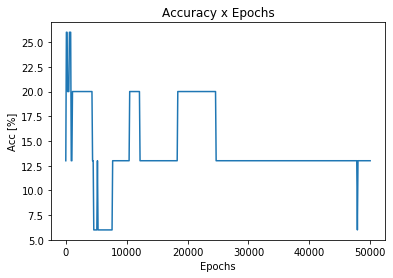

In [27]:
plt.plot(epoch_vali_acc,acc_vali_clean)
plt.title("Accuracy x Epochs")
plt.xlabel("Epochs")
plt.ylabel("Acc [%]")
plt.show()

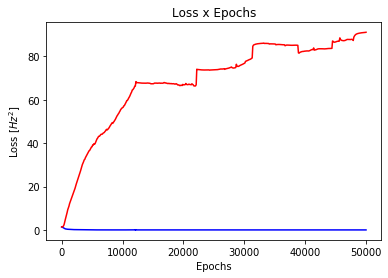

In [28]:
epoch = np.arange(0, epochs)
plt.plot(epoch,loss_train,'b')
plt.plot(epoch_vali,loss_vali_clean, 'r')
plt.title("Loss x Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss [$Hz^2$]")
plt.show()

D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


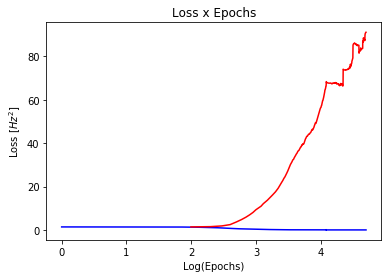

In [29]:
plt.figure()
plt.plot(np.log10(epoch),loss_train,'b')
plt.plot(np.log10(epoch_vali),loss_vali_clean, 'r')
plt.title("Loss x Epochs")
plt.xlabel("Log(Epochs)")
plt.ylabel("Loss [$Hz^2$]")
plt.show()

# Load best model

In [30]:
# to load
checkpoint = torch.load('model_best.pth.tar')
net.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

## REDE ORIGINAL

LR = 0.05
EPOCHS = 5000

Teste Loss: 0.0412
Teste Cosine Similarity: 0.8737


Errors: 41; Accuracy: 34%
Teste Loss: 3.9771
R-corrcoef: 0.12978560816684884


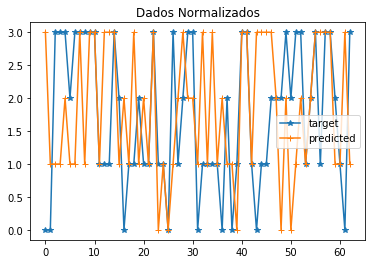

In [31]:
# # Transformando o dado de teste
# X_test_scaled = scaler_x.transform(X_test)
# #y_test_scaled = scaler_y.fit_transform(y_test)
# y_test_scaled = y_test_class

# Avaliando a acurácia do modelo utilizando os dados de teste transformados
inputs = torch.autograd.Variable(torch.Tensor(X_test_scaled.astype(np.float32)).float())
targets = torch.autograd.Variable(torch.Tensor(y_test_class).long())

optimizer.zero_grad()
out = net(inputs)
loss = criterion(out, targets.squeeze())
loss.backward()
optimizer.step()

#predicted = out.data
_, predicted = torch.max(out.data, 1) # Usar dessa forma?        

error_count = y_test_class.size - np.count_nonzero((targets.squeeze() == predicted) .numpy())
acc = 100 * torch.sum(targets.squeeze() == predicted) /  y_test_class.size
r = np.corrcoef(predicted.detach().numpy().squeeze(), targets.detach().numpy().squeeze())[0,1]

print('Errors: %d; Accuracy: %d%%' % (error_count, acc))
print('Teste Loss: %.4f' % (loss.item()))
print('R-corrcoef: %s' % (str(r)))

# # Implementando a métrica do Cosine Similarity
# cos = nn.CosineSimilarity(dim=0, eps=1e-6)
# cos_sim = cos(targets, predicted)
# print('Teste Cosine Similarity: %.4f' % (cos_sim.item()))

ninput = np.arange(len(X_test))
plt.figure()
plt.plot(ninput, y_test_class, '-*', label = 'target')
plt.plot(ninput, predicted.numpy(), '-+', label = 'predicted')
plt.title('Dados Normalizados')
plt.legend()
plt.show()

In [44]:
C = confusion_matrix(targets,predicted, labels=[0, 1, 2, 3])
C

array([[ 1,  3,  2,  3],
       [ 2,  9,  2,  8],
       [ 2,  5,  2,  2],
       [ 0,  7,  5, 10]], dtype=int64)

In [42]:
C = C/np.sum(C, axis=1, keepdims=True)*100
C

array([[11.11111111, 33.33333333, 22.22222222, 33.33333333],
       [ 9.52380952, 42.85714286,  9.52380952, 38.0952381 ],
       [18.18181818, 45.45454545, 18.18181818, 18.18181818],
       [ 0.        , 31.81818182, 22.72727273, 45.45454545]])

In [35]:
i=1
number_str = str(i)
zero_filled_number = number_str.zfill(5)
print(zero_filled_number)

00001
